In [53]:
import matplotlib.pyplot as plt

In [54]:
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
import numpy as np

# Supported files:
# 1. a9a.txt
# 2. w8a.txt
# 3. ijcnn1
# 4. covtype.libsvm.binary

def data_loader(file_name='a9a.txt'):
    # Load in data and get rid of last column
    X, y = load_svmlight_file(file_name)
    
    # Convert to numpy array
    X = X.todense()
    return X, y



In [55]:
X, y = data_loader('a9a.txt')

print(X.shape)

(32561, 123)


In [56]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
from sklearn.covariance import GraphicalLasso

cov = GraphicalLasso(max_iter=1000).fit(X_train)

A = cov.covariance_

In [58]:
def lossfn(U, w, x, A, lambda_=1e-5):
    # U -> input, w -> label
    f = np.mean( 1 / ( 1 + np.exp(np.dot(U, x) * w)) ) 
    g = lambda_ * np.linalg.norm(np.dot(A, x), ord=1)
    return f + g

In [59]:
def gradf(U, w, x):
    # U (n,d) ; w (n,1) ; x (d,1)
    expfn = 1 / ( 1 + np.exp(np.dot(U, x) * w)) # (n,1)
    return np.mean( expfn * ( expfn - 1 ) * (U * w), axis = 0).reshape(x.shape)

In [30]:
def soft_threshold(x, t=1):
    return np.sign(x) * np.maximum( np.abs(x) - t, 0)

def update_y(x, y, z, rho, A, lambda_):
    return 1 / (rho + 1) * soft_threshold(rho * np.dot(A, x) + y - z, lambda_)

In [31]:
def update_x(x, y, z, v, rho, eta, A):
    return x - eta * ( v + rho * np.dot(A, (np.dot(A, x) - y - z / rho) ))

In [32]:
def update_s(rho, A, B, z_1, z_0):
    return rho * A.T @ B @ (z_1 - z_0)

def update_r(A, B, x, z, c):
    return A @ x + B @ z - c

def update_rho(rho, r, s, mu=1.25, tau_incr=1.25, tau_decr=1.25):
    r_n = np.linalg.norm(r, ord=2)
    s_n = np.linalg.norm(s, ord=2)
    if r_n > mu*s_n:
        return tau_incr * rho
    if s_n > mu*r_n:
        return rho / tau_decr
    return rho

In [33]:
#U = X_train
#w = y_train
def spider_admm(b, q, K, eta, rho, U, w, A, lambda_):
    n, d = U.shape
    x = np.zeros((d,1)) # ai^\top x_i 
    y = np.zeros((d,1)) # Ay
    z = np.zeros((d,1)) # 
    w = w.reshape((len(w), 1))
    B = -np.eye(d)
    c = np.zeros((d,1))
    #dual residual
    s = np.zeros((d,1))
    #primal residual
    r = np.zeros((d,1))

    
    xprev = x.copy()
    ind = np.random.permutation(np.arange(n))
    i = 0
    loss = []

    for k in range(K):
        if (k % q) == 0:
            vk = gradf(U, w, x) # check how gradient is solved
        else:
            indb = ind[i:i+b]
            i += b
            if i >= n:
                i = 0
            Ub, wb = U[indb, :], w[indb]
            vk = gradf(Ub, wb, x) - gradf(Ub, wb, xprev) + vk            
        
        print(vk)
        rho = update_rho(rho, r, s)
        
        y = update_y(x, y, z, rho, A, lambda_)
        xprev = x.copy()
        x = update_x(x, y, z, vk, rho, eta, A)
        z_0 = z.copy()
        z = z - rho * (A @ x + B @ y - c)
        s = update_s(rho, A, B, z_1=z, z_0=z_0)
        r = update_r(A, B, x, z, c)

        l = lossfn(U, w, x, A, lambda_)
        # print("k:", k, "Loss:", l)
        print("k:", k,"rho:",rho,"r:",np.linalg.norm(r, ord=2),"s:",np.linalg.norm(s, ord=2),"Loss:", l)
        loss.append(l)
    
    return x, y, z, loss

In [32]:
b = 32
q = 10
eta = 0.05
rho = 0.5
lambda_ = 1e-5
K = 5000
x, y, z, loss = spider_admm(b, q, K, eta, rho, X_train, y_train, A, lambda_)

k: 0 rho: 0.5 r: 0.09110769104123244 s: 0.07085431225553186 Loss: 0.49629552786052167
k: 1 rho: 0.625 r: 0.12755235104506518 s: 0.05983498390455367 Loss: 0.4951455891145371
k: 2 rho: 0.78125 r: 0.14605777713716023 s: 0.014011934433931141 Loss: 0.49409076511684147
k: 3 rho: 0.9765625 r: 0.17962481557567522 s: 0.018301538222914245 Loss: 0.492198745019719
k: 4 rho: 1.220703125 r: 0.2164163665954271 s: 0.03988227876108134 Loss: 0.49024860213284305
k: 5 rho: 1.52587890625 r: 0.2539498324442219 s: 0.05831695256251424 Loss: 0.48834042031776276
k: 6 rho: 1.9073486328125 r: 0.2952533290071991 s: 0.10119782334865662 Loss: 0.48641639580068385
k: 7 rho: 2.384185791015625 r: 0.33759023826418655 s: 0.14297185125043677 Loss: 0.48453334071469406
k: 8 rho: 2.9802322387695312 r: 0.38588424838703594 s: 0.25385501120668535 Loss: 0.4826212042629846
k: 9 rho: 3.725290298461914 r: 0.43384273797460726 s: 0.32342821562124396 Loss: 0.4807675403104727
k: 10 rho: 4.656612873077393 r: 0.49562703344036496 s: 0.6831

Text(0.5, 1.0, 'SPIDER-ADMM')

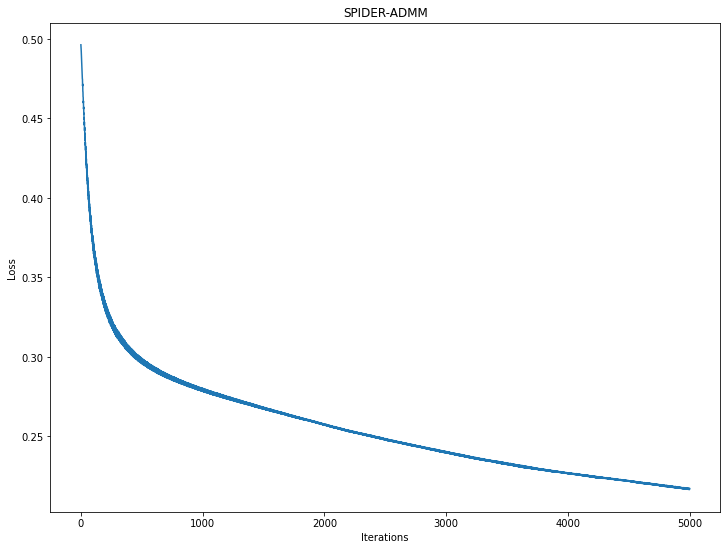

In [33]:
plt.figure(figsize=(12,9))
plt.plot(loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("SPIDER-ADMM")

In [64]:
#U = X_train
#w = y_train
def SAGA_admm(K, eta, rho, U, w, A, lambda_):
    d_z = {} # dictionary of z_s
    
    n, d = U.shape
    x = np.zeros((d,1)) # x0
    y = np.zeros((d,1)) # y0
    lamb = np.zeros((d,1)) # init 
    w = w.reshape((len(w), 1))
    B = -np.eye(d)
    c = np.zeros((d,1))
    #dual residual
    s = np.zeros((d,1))
    #primal residual
    r = np.zeros((d,1))

    
    i = 0
    loss = []
    
    # PSI INIT
    psi  = gradf(U, w, np.zeros((d,1)))
    
    for k in range(K):
        # Uniformly randomly pick i_t and j_t from [1,n]
        it, jt = np.random.randint(n), np.random.randint(n)
        
        # Grab z (might have to fix this) is it really z_it ^ t
        z = None
        if it not in d_z:
            d_z[it] = np.zeros((d,1))
        if jt not in d_z:
            d_z[jt] = np.zeros((d,1))
        z = d_z[it]
        
        # Update rho
        rho = update_rho(rho, r, s)
        
        # Update y
        y = update_y(x, y, lamb, rho, A, lambda_)
        
        # Compute gradient
        Ub, wb = U[it, :], w[it].reshape(-1, 1)
        vk = gradf(Ub, wb, x) - gradf(Ub, wb, z) + psi
        
        # Update x
        xprev = x.copy()
        x = update_x(x, y, lamb, vk, rho, eta, A)
        
        # Update lamb
        lamb_0 = lamb.copy()
        lamb = lamb - rho * (A @ x + B @ y - c)
        
        # Update z
        z_jt_prev = d_z[jt]
        d_z[jt] = xprev
        
        # Update psi
        Ub, wb = U[jt, :], w[jt].reshape(-1, 1)
        psi = psi - 1/n * (gradf(Ub, wb,  z_jt_prev) - gradf(Ub, wb, d_z[jt]))
        
        # Update s/r
        s = update_s(rho, A, B, z_1=lamb, z_0=lamb_0)
        r = update_r(A, B, x, lamb, c)

        l = lossfn(U, w, x, A, lambda_)
        # print("k:", k, "Loss:", l)
        print("k:", k,"rho:",rho,"r:",np.linalg.norm(r, ord=2),"s:",np.linalg.norm(s, ord=2),"Loss:", l)
        loss.append(l)
    
    return x, y, z, loss

In [65]:
eta = 0.05
rho = 0.5
lambda_ = 1e-5
K = 5000
x, y, z, loss = SAGA_admm(K, eta, rho, X_train, y_train, A, lambda_)

k: 0 rho: 0.5 r: 0.09047496637367204 s: 0.06972608348223804 Loss: 0.49629635810319433
k: 1 rho: 0.625 r: 0.12798443157410835 s: 0.06039710173518708 Loss: 0.49511193050833124
k: 2 rho: 0.78125 r: 0.14686440007307408 s: 0.01478702520221444 Loss: 0.4940517203745937
k: 3 rho: 0.9765625 r: 0.1798517099446776 s: 0.016767379910619745 Loss: 0.49217050240953464
k: 4 rho: 1.220703125 r: 0.2171602983178565 s: 0.04075079279909345 Loss: 0.4901958614901398
k: 5 rho: 1.52587890625 r: 0.25485204131226985 s: 0.05811977628748935 Loss: 0.4882766924654491
k: 6 rho: 1.9073486328125 r: 0.2966632502097313 s: 0.10266894194412152 Loss: 0.4863333334961211
k: 7 rho: 2.384185791015625 r: 0.3361198943272011 s: 0.11705858370953126 Loss: 0.48448752790602173
k: 8 rho: 2.9802322387695312 r: 0.3876752282711063 s: 0.29325690758035755 Loss: 0.4825518077686273
k: 9 rho: 3.725290298461914 r: 0.43429852904353605 s: 0.3128680521455286 Loss: 0.4806999896011903
k: 10 rho: 4.656612873077393 r: 0.5015192363649691 s: 0.7794009614

k: 132 rho: 1.9073486328125 r: 2.6589369316910623 s: 3.6372336165912107 Loss: 0.3611420153988235
k: 133 rho: 1.52587890625 r: 3.2416041201137213 s: 2.625538275930406 Loss: 0.35452925463948914
k: 134 rho: 1.52587890625 r: 2.995664021212237 s: 2.0875005367164943 Loss: 0.35723449879961194
k: 135 rho: 1.9073486328125 r: 3.494842197480705 s: 4.090953025929202 Loss: 0.35167687232899986
k: 136 rho: 1.9073486328125 r: 2.606100381162993 s: 6.370482144646269 Loss: 0.35852872152375
k: 137 rho: 1.52587890625 r: 3.5095087434661907 s: 4.257685895862648 Loss: 0.34871025026995794
k: 138 rho: 1.52587890625 r: 3.1591253413340943 s: 1.7029581304847043 Loss: 0.35267634089654765
k: 139 rho: 1.9073486328125 r: 3.4144930104225737 s: 1.5065366117538794 Loss: 0.34926515583432644
k: 140 rho: 2.384185791015625 r: 3.164558470548482 s: 2.430540870444112 Loss: 0.3503968574862657
k: 141 rho: 2.9802322387695312 r: 3.6240377001823676 s: 4.919148346841038 Loss: 0.34713228869248564
k: 142 rho: 2.384185791015625 r: 2.642

k: 274 rho: 1.9073486328125 r: 4.090578980686247 s: 3.7899968085912223 Loss: 0.33039010118659434
k: 275 rho: 1.9073486328125 r: 4.943002578964157 s: 5.604615264707872 Loss: 0.3257408423949878
k: 276 rho: 1.9073486328125 r: 3.78503845398175 s: 8.229397624736414 Loss: 0.3324082510639457
k: 277 rho: 1.52587890625 r: 5.043301318738298 s: 6.308323607662788 Loss: 0.32440651969783824
k: 278 rho: 1.220703125 r: 4.158918771122544 s: 3.004075882256443 Loss: 0.3310180048878889
k: 279 rho: 1.52587890625 r: 4.853742672950176 s: 2.9089520065298693 Loss: 0.3254685040664193
k: 280 rho: 1.9073486328125 r: 4.220933909522794 s: 4.447007462047493 Loss: 0.32872918306272836
k: 281 rho: 1.9073486328125 r: 4.985823246243365 s: 5.030025303812359 Loss: 0.3243953966775061
k: 282 rho: 1.9073486328125 r: 4.2076436212239186 s: 5.450847064834295 Loss: 0.32813008188590975
k: 283 rho: 1.52587890625 r: 4.975146097872233 s: 3.7637580820763095 Loss: 0.32328223078012186
k: 284 rho: 1.9073486328125 r: 4.250835688129689 s: 

k: 421 rho: 1.52587890625 r: 5.50551191273025 s: 5.181643573490612 Loss: 0.30560630294336893
k: 422 rho: 1.52587890625 r: 6.535601705591563 s: 5.047116954147006 Loss: 0.3026865268692761
k: 423 rho: 1.9073486328125 r: 5.545286259217707 s: 7.008373275518736 Loss: 0.30535284772478244
k: 424 rho: 1.52587890625 r: 6.556201882164111 s: 5.35805684219188 Loss: 0.30240643848304166
k: 425 rho: 1.52587890625 r: 5.758910282494891 s: 3.271126653573218 Loss: 0.3049847105673726
k: 426 rho: 1.9073486328125 r: 6.466658376620572 s: 4.510838633724917 Loss: 0.3029035648319843
k: 427 rho: 2.384185791015625 r: 5.788330453166176 s: 6.418031959807402 Loss: 0.3043191492210318
k: 428 rho: 2.384185791015625 r: 5.931556236654868 s: 5.1031908602250216 Loss: 0.306261595683526
k: 429 rho: 2.384185791015625 r: 6.548646822738163 s: 7.241415715175088 Loss: 0.3038388419093421
k: 430 rho: 2.384185791015625 r: 5.511840627955719 s: 9.211067888518679 Loss: 0.305953544317843
k: 431 rho: 1.9073486328125 r: 6.7400018885726 s: 

k: 564 rho: 1.52587890625 r: 5.906371133702119 s: 6.443091206318645 Loss: 0.307371235347447
k: 565 rho: 1.52587890625 r: 6.632779727983646 s: 4.343767000644893 Loss: 0.3047893839666077
k: 566 rho: 1.9073486328125 r: 5.897057271425185 s: 6.218607308134773 Loss: 0.30763982946924373
k: 567 rho: 1.9073486328125 r: 6.642670818101557 s: 5.911076700523637 Loss: 0.3051495062432387
k: 568 rho: 1.9073486328125 r: 6.075909062136172 s: 3.8085712241653904 Loss: 0.30702185701393847
k: 569 rho: 2.384185791015625 r: 6.659261502042717 s: 5.563733709099994 Loss: 0.3056236513574983
k: 570 rho: 2.384185791015625 r: 6.092372411232271 s: 5.729351520485942 Loss: 0.30688200791463094
k: 571 rho: 2.384185791015625 r: 6.367930082492297 s: 3.849451473755312 Loss: 0.3055617727821227
k: 572 rho: 2.9802322387695312 r: 6.064234320825054 s: 6.83296311911626 Loss: 0.3065082924774425
k: 573 rho: 2.9802322387695312 r: 6.840502312427373 s: 11.919220500276948 Loss: 0.3049592804671094
k: 574 rho: 2.384185791015625 r: 5.7193

k: 707 rho: 1.9073486328125 r: 7.439794526110003 s: 7.478306339172368 Loss: 0.30002057433516904
k: 708 rho: 1.9073486328125 r: 6.517533521199099 s: 6.0490645521873985 Loss: 0.30245673965782965
k: 709 rho: 1.9073486328125 r: 7.25250766243765 s: 5.913458347609188 Loss: 0.3003806414341946
k: 710 rho: 1.9073486328125 r: 6.592770641001916 s: 5.23716057436483 Loss: 0.30139692195308415
k: 711 rho: 2.384185791015625 r: 7.627015117489065 s: 9.335310288755505 Loss: 0.29960538088025546
k: 712 rho: 2.384185791015625 r: 6.31037675836863 s: 13.360792391547774 Loss: 0.30183090684676867
k: 713 rho: 1.9073486328125 r: 7.7030421443981645 s: 10.357241042839139 Loss: 0.2993679023841067
k: 714 rho: 1.52587890625 r: 6.630474636907196 s: 5.444868422978797 Loss: 0.302640577735425
k: 715 rho: 1.52587890625 r: 7.301892918368076 s: 2.646869597585021 Loss: 0.30016468821869635
k: 716 rho: 1.9073486328125 r: 7.026043910615168 s: 2.839464613093002 Loss: 0.30181878645835764
k: 717 rho: 2.384185791015625 r: 7.83506072

k: 851 rho: 1.9073486328125 r: 8.127030158061821 s: 6.607749038323465 Loss: 0.2977834313350586
k: 852 rho: 1.9073486328125 r: 7.277753277695727 s: 6.050364375819053 Loss: 0.2991519165824985
k: 853 rho: 1.9073486328125 r: 8.38488416000667 s: 7.5932477232676945 Loss: 0.2976712232183508
k: 854 rho: 1.9073486328125 r: 6.893722704005801 s: 11.36641494315809 Loss: 0.2997124697799344
k: 855 rho: 1.52587890625 r: 8.619363158759597 s: 9.369440090985655 Loss: 0.29702839548871096
k: 856 rho: 1.52587890625 r: 7.160751631688259 s: 6.53185141187089 Loss: 0.2995017255082632
k: 857 rho: 1.52587890625 r: 8.393091498389182 s: 5.435848132646156 Loss: 0.29720165781653235
k: 858 rho: 1.9073486328125 r: 6.978888035123104 s: 9.805127548839339 Loss: 0.29895832447531767
k: 859 rho: 1.52587890625 r: 8.446342595910792 s: 7.65342594150081 Loss: 0.2965468915062104
k: 860 rho: 1.52587890625 r: 7.210295781927678 s: 5.615817635726206 Loss: 0.29884057008659004
k: 861 rho: 1.9073486328125 r: 8.27255059979987 s: 7.45802

k: 999 rho: 1.52587890625 r: 8.809327530042477 s: 6.6027621490433805 Loss: 0.29577839290371527
k: 1000 rho: 1.9073486328125 r: 7.310890074539289 s: 9.873330584678195 Loss: 0.2969689056930264
k: 1001 rho: 1.52587890625 r: 8.495096223539646 s: 6.144134754093711 Loss: 0.29497225485591017
k: 1002 rho: 1.9073486328125 r: 7.538849752288426 s: 6.561559417887639 Loss: 0.2961536868649005
k: 1003 rho: 1.9073486328125 r: 8.686737080925404 s: 8.976522885239982 Loss: 0.29478642149531986
k: 1004 rho: 1.9073486328125 r: 7.749159224546217 s: 6.282717705822038 Loss: 0.29569743838899903
k: 1005 rho: 1.9073486328125 r: 8.518750801361378 s: 5.094064393087338 Loss: 0.2950768393123539
k: 1006 rho: 2.384185791015625 r: 7.5804269985737704 s: 8.68540939789032 Loss: 0.29720888900420656
k: 1007 rho: 2.384185791015625 r: 8.401452857231202 s: 7.5557094175379085 Loss: 0.2957059809557983
k: 1008 rho: 2.384185791015625 r: 7.873683389779751 s: 5.8843459853927245 Loss: 0.29578922700209387
k: 1009 rho: 2.980232238769531

k: 1143 rho: 1.220703125 r: 8.814904980475774 s: 3.866198464342063 Loss: 0.2927821888510513
k: 1144 rho: 1.52587890625 r: 8.11772983188846 s: 2.726448708817831 Loss: 0.2941697915235712
k: 1145 rho: 1.9073486328125 r: 8.836077637481152 s: 4.510843364219044 Loss: 0.2930445710882517
k: 1146 rho: 2.384185791015625 r: 7.908655183002588 s: 8.402845529642684 Loss: 0.2942215850398789
k: 1147 rho: 2.384185791015625 r: 9.075970836821678 s: 12.276519905302028 Loss: 0.2923685568980534
k: 1148 rho: 1.9073486328125 r: 7.70899218545876 s: 10.782525284516298 Loss: 0.29462689133338965
k: 1149 rho: 1.52587890625 r: 8.793154886565645 s: 5.815930065197428 Loss: 0.2920884935605354
k: 1150 rho: 1.9073486328125 r: 8.669044417120412 s: 1.8723269213384004 Loss: 0.29216494769083456
k: 1151 rho: 2.384185791015625 r: 8.66524207901218 s: 1.7962653357292584 Loss: 0.2922349010921889
k: 1152 rho: 2.9802322387695312 r: 8.273594814904799 s: 6.079222867240746 Loss: 0.29264017333555803
k: 1153 rho: 3.725290298461914 r: 8

k: 1293 rho: 1.52587890625 r: 9.488892372177302 s: 10.214148403390404 Loss: 0.28800234840292643
k: 1294 rho: 1.52587890625 r: 8.033167376803249 s: 6.6751070120319165 Loss: 0.2912280399784933
k: 1295 rho: 1.52587890625 r: 8.966303505624413 s: 4.4211575178835885 Loss: 0.2887229501711743
k: 1296 rho: 1.9073486328125 r: 7.655383238961794 s: 9.150318419068467 Loss: 0.2919723564758003
k: 1297 rho: 1.9073486328125 r: 9.000946353236817 s: 9.547451065991703 Loss: 0.28921766038286
k: 1298 rho: 1.9073486328125 r: 7.927856379128646 s: 7.908984553162086 Loss: 0.29146131839566797
k: 1299 rho: 1.9073486328125 r: 9.02483375118864 s: 8.872908843811738 Loss: 0.28974111317369755
k: 1300 rho: 1.9073486328125 r: 7.173257234182194 s: 12.625318291692347 Loss: 0.29488870343985146
k: 1301 rho: 1.52587890625 r: 9.34061089564633 s: 11.732660562458124 Loss: 0.28987000213860037
k: 1302 rho: 1.220703125 r: 7.622606559446507 s: 5.880882419436389 Loss: 0.29375561155171515
k: 1303 rho: 1.52587890625 r: 8.6956152736012

k: 1436 rho: 1.9073486328125 r: 8.545839089737242 s: 6.3063835716781504 Loss: 0.2840606764117699
k: 1437 rho: 2.384185791015625 r: 9.482423738179952 s: 9.505868546218203 Loss: 0.28321024560278085
k: 1438 rho: 2.384185791015625 r: 8.250119073662486 s: 13.010473101373426 Loss: 0.28520725606007263
k: 1439 rho: 1.9073486328125 r: 10.019270377509054 s: 13.778000372412537 Loss: 0.28243924401178
k: 1440 rho: 1.52587890625 r: 8.343660887713353 s: 9.052272794576332 Loss: 0.28564110113024277
k: 1441 rho: 1.52587890625 r: 9.474037519899307 s: 5.7846015290842265 Loss: 0.28400994850123085
k: 1442 rho: 1.9073486328125 r: 8.622443824616608 s: 6.493071816045815 Loss: 0.28507463869964256
k: 1443 rho: 2.384185791015625 r: 10.169283366805763 s: 15.07821861527882 Loss: 0.2831411223893384
k: 1444 rho: 1.9073486328125 r: 8.551090176555977 s: 12.433598605020848 Loss: 0.2850797689165209
k: 1445 rho: 1.52587890625 r: 9.887560400574984 s: 7.010412781992371 Loss: 0.28225432038817144
k: 1446 rho: 1.9073486328125 

k: 1584 rho: 1.52587890625 r: 9.521667936626088 s: 6.226217669465578 Loss: 0.28136212192673754
k: 1585 rho: 1.9073486328125 r: 10.951573709395618 s: 10.433200592079018 Loss: 0.28058735380993255
k: 1586 rho: 1.9073486328125 r: 9.495597918918113 s: 11.134924757449744 Loss: 0.2816067913923937
k: 1587 rho: 1.9073486328125 r: 10.877410848005315 s: 9.241226502849383 Loss: 0.28102622272659006
k: 1588 rho: 1.9073486328125 r: 8.785292543422235 s: 13.563530434416947 Loss: 0.2830115522319189
k: 1589 rho: 1.52587890625 r: 10.971331868045866 s: 11.665303482947072 Loss: 0.281396059637209
k: 1590 rho: 1.52587890625 r: 8.894730245102002 s: 10.211652833144317 Loss: 0.2836163173229051
k: 1591 rho: 1.52587890625 r: 11.09108931277649 s: 10.465421722883617 Loss: 0.2818834259756368
k: 1592 rho: 1.52587890625 r: 9.734545278442514 s: 6.905954375208391 Loss: 0.2828746540208678
k: 1593 rho: 1.9073486328125 r: 11.11428583474839 s: 8.37597085726261 Loss: 0.2810685264290446
k: 1594 rho: 2.384185791015625 r: 8.9209

k: 1730 rho: 1.52587890625 r: 9.732887365201922 s: 7.339939800773842 Loss: 0.28805064076276976
k: 1731 rho: 1.9073486328125 r: 10.53568557532686 s: 7.323964020101743 Loss: 0.287939188854459
k: 1732 rho: 2.384185791015625 r: 9.54969172722616 s: 10.786159131042268 Loss: 0.288489408826513
k: 1733 rho: 2.384185791015625 r: 10.786108003431208 s: 12.408369045180097 Loss: 0.2871783082134324
k: 1734 rho: 2.384185791015625 r: 9.11466144598404 s: 15.841266104668675 Loss: 0.2885238055938068
k: 1735 rho: 1.9073486328125 r: 10.89386371774403 s: 13.511191058871676 Loss: 0.2870264031098493
k: 1736 rho: 1.9073486328125 r: 9.002309736952377 s: 13.637502977850017 Loss: 0.28869372129379767
k: 1737 rho: 1.52587890625 r: 11.21392393864047 s: 11.428230473591631 Loss: 0.28569358298468667
k: 1738 rho: 1.52587890625 r: 9.523463167833942 s: 7.619895783116049 Loss: 0.2881199253246057
k: 1739 rho: 1.52587890625 r: 10.47284776205553 s: 4.553402348190056 Loss: 0.2863393963073402
k: 1740 rho: 1.9073486328125 r: 9.71

k: 1871 rho: 1.9073486328125 r: 8.987464980016531 s: 16.6478075668196 Loss: 0.2900052349035491
k: 1872 rho: 1.52587890625 r: 10.814280620094406 s: 9.568039136038552 Loss: 0.2873168306863571
k: 1873 rho: 1.52587890625 r: 9.360368323288748 s: 6.907378742378099 Loss: 0.28939024736497077
k: 1874 rho: 1.9073486328125 r: 10.61645707045053 s: 9.014468190797134 Loss: 0.28794668710903565
k: 1875 rho: 1.9073486328125 r: 9.64501297163706 s: 6.994882302821756 Loss: 0.28868621713000375
k: 1876 rho: 2.384185791015625 r: 10.781159082276183 s: 10.028781628726787 Loss: 0.28695759150036004
k: 1877 rho: 2.384185791015625 r: 9.325450769100168 s: 13.942029374780441 Loss: 0.2882947481123839
k: 1878 rho: 1.9073486328125 r: 10.884653991715416 s: 10.62193284847873 Loss: 0.28748986536242577
k: 1879 rho: 1.9073486328125 r: 9.363436084690157 s: 10.51916420173466 Loss: 0.28977568318366026
k: 1880 rho: 1.9073486328125 r: 11.149176558849781 s: 12.652051989192971 Loss: 0.28760200051952645
k: 1881 rho: 1.9073486328125

k: 2012 rho: 1.9073486328125 r: 11.576429083843534 s: 9.144695590877332 Loss: 0.2880728309714263
k: 2013 rho: 2.384185791015625 r: 9.63575643143594 s: 18.268086589176864 Loss: 0.28929312510691974
k: 2014 rho: 1.9073486328125 r: 12.003390595815905 s: 16.826713421202772 Loss: 0.28773589816119965
k: 2015 rho: 1.52587890625 r: 9.952589445087222 s: 11.131952375263118 Loss: 0.2890049461488638
k: 2016 rho: 1.52587890625 r: 11.695624497264012 s: 8.544062457399516 Loss: 0.28676086595076866
k: 2017 rho: 1.9073486328125 r: 9.429354536810688 s: 14.961480304476481 Loss: 0.2901657720832801
k: 2018 rho: 1.52587890625 r: 12.066410686525966 s: 14.421802917092904 Loss: 0.287835667150186
k: 2019 rho: 1.52587890625 r: 9.215115830611476 s: 14.8508684366298 Loss: 0.2894452632340245
k: 2020 rho: 1.220703125 r: 11.776255253856082 s: 9.652395225898422 Loss: 0.28693891453694814
k: 2021 rho: 1.220703125 r: 10.404003658912753 s: 3.7981608032543974 Loss: 0.28872571348604664
k: 2022 rho: 1.52587890625 r: 11.2522116

k: 2157 rho: 2.384185791015625 r: 11.547447561595705 s: 12.161369409546998 Loss: 0.2801402837793642
k: 2158 rho: 2.384185791015625 r: 10.342702791939775 s: 13.383290354624611 Loss: 0.2807131883040996
k: 2159 rho: 1.9073486328125 r: 12.061032769731986 s: 13.501149252507796 Loss: 0.2798457551995737
k: 2160 rho: 1.9073486328125 r: 9.46344795243232 s: 18.52601598072539 Loss: 0.28152132268919455
k: 2161 rho: 1.52587890625 r: 12.243729822236503 s: 14.907047149144583 Loss: 0.27953411434743264
k: 2162 rho: 1.52587890625 r: 9.667802001253653 s: 12.627225883392612 Loss: 0.2816035092151916
k: 2163 rho: 1.220703125 r: 11.795680516384191 s: 7.899749633017142 Loss: 0.2793244586917344
k: 2164 rho: 1.52587890625 r: 10.101817431030376 s: 8.099244155030068 Loss: 0.2806334204751665
k: 2165 rho: 1.52587890625 r: 11.683961187894033 s: 8.520626697650785 Loss: 0.27970559893998426
k: 2166 rho: 1.9073486328125 r: 9.945996624035708 s: 11.491338323895555 Loss: 0.2804035671314325
k: 2167 rho: 1.9073486328125 r: 1

k: 2306 rho: 1.52587890625 r: 10.062287110814772 s: 8.198135983253072 Loss: 0.2836221794044586
k: 2307 rho: 1.52587890625 r: 11.650860975499178 s: 7.995056471869321 Loss: 0.2818186798508996
k: 2308 rho: 1.9073486328125 r: 10.098233201305604 s: 10.8066639819383 Loss: 0.2833326262581462
k: 2309 rho: 1.9073486328125 r: 11.530471093682264 s: 10.980588050163131 Loss: 0.28185113908736925
k: 2310 rho: 1.9073486328125 r: 9.957105687106019 s: 11.029141372686027 Loss: 0.28284673449023934
k: 2311 rho: 1.9073486328125 r: 11.506672428146276 s: 11.637961204948287 Loss: 0.2814320793194214
k: 2312 rho: 1.9073486328125 r: 10.453067882267598 s: 8.955708826391486 Loss: 0.2827657412450894
k: 2313 rho: 1.9073486328125 r: 11.600025928263399 s: 10.062714091578759 Loss: 0.28158120817297777
k: 2314 rho: 1.9073486328125 r: 9.600919179633994 s: 15.50717283842217 Loss: 0.2832410902499141
k: 2315 rho: 1.52587890625 r: 11.984868419228613 s: 13.042227292489498 Loss: 0.2808172769642826
k: 2316 rho: 1.52587890625 r: 9

k: 2453 rho: 1.9073486328125 r: 10.484131383642122 s: 8.427942823023674 Loss: 0.2861543798375431
k: 2454 rho: 1.9073486328125 r: 12.286332307089786 s: 11.236955328611755 Loss: 0.28421077546550555
k: 2455 rho: 1.9073486328125 r: 10.016822335462201 s: 13.812865761271075 Loss: 0.28759355540114057
k: 2456 rho: 1.52587890625 r: 11.662361389087167 s: 7.866266444945523 Loss: 0.28454964186401244
k: 2457 rho: 1.9073486328125 r: 10.315983413229413 s: 8.728208780072826 Loss: 0.28703501202195164
k: 2458 rho: 1.9073486328125 r: 12.014616413750996 s: 12.261519187189197 Loss: 0.28522722432038033
k: 2459 rho: 1.9073486328125 r: 10.865927734172509 s: 9.90347174700549 Loss: 0.28533824184210915
k: 2460 rho: 1.9073486328125 r: 11.409741495123718 s: 6.195190372122529 Loss: 0.28481473306598304
k: 2461 rho: 2.384185791015625 r: 10.397030498413669 s: 12.242507114101295 Loss: 0.28527128924619943
k: 2462 rho: 2.384185791015625 r: 12.35587018573336 s: 20.958019260129223 Loss: 0.2837683757104799
k: 2463 rho: 1.90

k: 2598 rho: 1.52587890625 r: 12.15137364009239 s: 10.43703800606656 Loss: 0.2817206184305787
k: 2599 rho: 1.52587890625 r: 10.928872786937443 s: 6.074362992672814 Loss: 0.28331134268544295
k: 2600 rho: 1.9073486328125 r: 11.935521944044012 s: 7.381106740136968 Loss: 0.2825072360223557
k: 2601 rho: 2.384185791015625 r: 10.884389766564656 s: 10.68818682761464 Loss: 0.28334343578092464
k: 2602 rho: 2.384185791015625 r: 12.28282948982811 s: 14.93961124171211 Loss: 0.28293975086399625
k: 2603 rho: 2.384185791015625 r: 10.551237788116286 s: 18.44890108635614 Loss: 0.2843030700441128
k: 2604 rho: 1.9073486328125 r: 12.567807498643873 s: 15.3428135506913 Loss: 0.2823544956086619
k: 2605 rho: 1.9073486328125 r: 10.495160160911057 s: 15.138495198671853 Loss: 0.2845680571711659
k: 2606 rho: 1.52587890625 r: 12.503735195989774 s: 10.790442138367487 Loss: 0.28262580057337927
k: 2607 rho: 1.52587890625 r: 11.316396795726718 s: 6.383473795306945 Loss: 0.28380941377357966
k: 2608 rho: 1.9073486328125

k: 2741 rho: 1.52587890625 r: 10.971710190960039 s: 8.338188751831346 Loss: 0.28916704178085084
k: 2742 rho: 1.9073486328125 r: 12.82731811383329 s: 13.443182663638119 Loss: 0.2862732830577799
k: 2743 rho: 1.9073486328125 r: 10.872405876460036 s: 15.548372988862985 Loss: 0.28938468658121475
k: 2744 rho: 1.52587890625 r: 12.822699752743338 s: 11.262552851304466 Loss: 0.2859824902985558
k: 2745 rho: 1.52587890625 r: 10.96813845626831 s: 10.007600616862284 Loss: 0.2893174627675888
k: 2746 rho: 1.52587890625 r: 12.769182082142255 s: 9.812872442123277 Loss: 0.28591156028827347
k: 2747 rho: 1.9073486328125 r: 10.832946656809684 s: 14.109795240865367 Loss: 0.28869502933332775
k: 2748 rho: 1.52587890625 r: 12.46464935310908 s: 8.750688837321952 Loss: 0.28640003020604854
k: 2749 rho: 1.9073486328125 r: 11.125782727041424 s: 9.519471820408436 Loss: 0.288561226474008
k: 2750 rho: 1.9073486328125 r: 12.557492467656775 s: 11.516818258151318 Loss: 0.2874160548869324
k: 2751 rho: 1.9073486328125 r: 1

k: 2877 rho: 1.9073486328125 r: 10.828270077583516 s: 14.625562363641729 Loss: 0.2874817559006193
k: 2878 rho: 1.52587890625 r: 13.005226982415968 s: 11.66342288401743 Loss: 0.2852087340038015
k: 2879 rho: 1.52587890625 r: 11.253690853762912 s: 8.89864875726734 Loss: 0.28760158421289944
k: 2880 rho: 1.9073486328125 r: 12.808128872761943 s: 10.253221848001534 Loss: 0.2850016480561231
k: 2881 rho: 1.9073486328125 r: 10.840409163708307 s: 14.461405290637545 Loss: 0.28745347644061436
k: 2882 rho: 1.52587890625 r: 13.083264493095953 s: 12.43227063501275 Loss: 0.2842672699622458
k: 2883 rho: 1.52587890625 r: 10.890841451709202 s: 11.507242575989316 Loss: 0.28760755445417224
k: 2884 rho: 1.52587890625 r: 12.84184810293207 s: 10.607906491355644 Loss: 0.2844046768617064
k: 2885 rho: 1.52587890625 r: 10.975330350672634 s: 10.417651473301365 Loss: 0.2876220776090681
k: 2886 rho: 1.52587890625 r: 12.882122268840943 s: 10.046124366410119 Loss: 0.28525665731110517
k: 2887 rho: 1.9073486328125 r: 11.

k: 3017 rho: 2.9802322387695312 r: 11.421885141642186 s: 21.97562413784381 Loss: 0.2870459872735448
k: 3018 rho: 2.384185791015625 r: 13.30433986499671 s: 23.991363226074768 Loss: 0.28472877939765645
k: 3019 rho: 1.9073486328125 r: 11.570758995604425 s: 15.10167060000599 Loss: 0.2874079601614642
k: 3020 rho: 1.52587890625 r: 13.351799664981172 s: 10.451732563455836 Loss: 0.2840059066200081
k: 3021 rho: 1.9073486328125 r: 11.175359750509157 s: 14.944708559064777 Loss: 0.2870429834815551
k: 3022 rho: 1.52587890625 r: 13.334364108276594 s: 11.385444780770946 Loss: 0.28360332248454606
k: 3023 rho: 1.52587890625 r: 11.752394724717249 s: 9.363763074101977 Loss: 0.28660163673152617
k: 3024 rho: 1.9073486328125 r: 13.529119421998695 s: 14.541030729255679 Loss: 0.2834937008616645
k: 3025 rho: 1.9073486328125 r: 11.389141971676803 s: 17.271436075391758 Loss: 0.28677737015020427
k: 3026 rho: 1.52587890625 r: 13.217649548144935 s: 10.241617880527182 Loss: 0.28351196236998083
k: 3027 rho: 1.9073486

k: 3156 rho: 1.9073486328125 r: 13.88105261378942 s: 17.935429157287906 Loss: 0.2788974792347323
k: 3157 rho: 1.52587890625 r: 11.889083059956322 s: 11.510239617340808 Loss: 0.2839076108636655
k: 3158 rho: 1.52587890625 r: 13.41273842444963 s: 7.240764738613881 Loss: 0.28012662302172
k: 3159 rho: 1.9073486328125 r: 11.70197448370747 s: 11.721493183154932 Loss: 0.28274327814423017
k: 3160 rho: 1.9073486328125 r: 13.190372057476267 s: 11.84636245040156 Loss: 0.2794500800593567
k: 3161 rho: 1.9073486328125 r: 11.91920931250059 s: 11.42131976125374 Loss: 0.28230044602513465
k: 3162 rho: 1.9073486328125 r: 13.611449503605666 s: 14.358468762934802 Loss: 0.278993331581346
k: 3163 rho: 1.9073486328125 r: 11.339891155759958 s: 18.13528850939381 Loss: 0.2828603558476471
k: 3164 rho: 1.52587890625 r: 13.32527427269209 s: 11.775420585196663 Loss: 0.2782583746198243
k: 3165 rho: 1.52587890625 r: 11.92743673925461 s: 6.6214960574347 Loss: 0.28089495794815994
k: 3166 rho: 1.9073486328125 r: 13.320585

k: 3297 rho: 1.52587890625 r: 11.842588443602661 s: 11.822075991941448 Loss: 0.28167324110293385
k: 3298 rho: 1.52587890625 r: 13.775737331513504 s: 11.473081105701793 Loss: 0.2777094019259154
k: 3299 rho: 1.52587890625 r: 11.877496779891983 s: 10.91246670567165 Loss: 0.2810577132752947
k: 3300 rho: 1.52587890625 r: 14.112661588775637 s: 12.184621431003993 Loss: 0.27716003495818115
k: 3301 rho: 1.52587890625 r: 12.149789417012142 s: 10.321049278964596 Loss: 0.28019793513558644
k: 3302 rho: 1.52587890625 r: 13.739227075871504 s: 8.025485127689496 Loss: 0.27746228140573265
k: 3303 rho: 1.9073486328125 r: 12.23909719088268 s: 10.37677908471764 Loss: 0.27902529243335705
k: 3304 rho: 1.9073486328125 r: 13.894234226490457 s: 11.898180455520226 Loss: 0.27714588994863015
k: 3305 rho: 1.9073486328125 r: 11.933249902809358 s: 15.825458084647439 Loss: 0.27951373146605496
k: 3306 rho: 1.52587890625 r: 13.801420371410359 s: 11.127158150519028 Loss: 0.2769749390704177
k: 3307 rho: 1.52587890625 r: 1

k: 3432 rho: 2.384185791015625 r: 14.173332316977048 s: 19.524369409939663 Loss: 0.2790332351753071
k: 3433 rho: 1.9073486328125 r: 11.99030753816577 s: 17.52470477563025 Loss: 0.2819073321448248
k: 3434 rho: 1.52587890625 r: 13.798374991685138 s: 10.324135115647014 Loss: 0.27904718759771374
k: 3435 rho: 1.9073486328125 r: 11.47986770874408 s: 16.54074515613266 Loss: 0.2827086808319788
k: 3436 rho: 1.52587890625 r: 13.93996966663953 s: 13.909194113645079 Loss: 0.27933053426333126
k: 3437 rho: 1.52587890625 r: 11.964766574328282 s: 10.688831154970336 Loss: 0.28274996454970985
k: 3438 rho: 1.52587890625 r: 13.869338799080628 s: 11.177069378772018 Loss: 0.27952340528147296
k: 3439 rho: 1.52587890625 r: 12.021732024199938 s: 9.102683831788733 Loss: 0.28229928445348335
k: 3440 rho: 1.9073486328125 r: 13.68454593566687 s: 11.1040327764996 Loss: 0.27996960258325887
k: 3441 rho: 1.9073486328125 r: 12.125012957718727 s: 12.242016715367466 Loss: 0.2820760340265502
k: 3442 rho: 1.9073486328125 r:

k: 3572 rho: 1.9073486328125 r: 13.581031787240581 s: 12.628694838199939 Loss: 0.28130209133738243
k: 3573 rho: 1.9073486328125 r: 11.591345727266075 s: 15.484434014275521 Loss: 0.28453111738487635
k: 3574 rho: 1.52587890625 r: 13.680110113802622 s: 11.777631175258524 Loss: 0.2806311161286813
k: 3575 rho: 1.52587890625 r: 11.86124210579773 s: 9.901747817569694 Loss: 0.2844862428660552
k: 3576 rho: 1.52587890625 r: 13.526555502266023 s: 8.95117999352524 Loss: 0.28110304815658355
k: 3577 rho: 1.9073486328125 r: 11.98592296457411 s: 10.765970111541428 Loss: 0.28343551762817304
k: 3578 rho: 1.9073486328125 r: 13.579331814959902 s: 11.669357763487872 Loss: 0.28049949608529273
k: 3579 rho: 1.9073486328125 r: 11.96988544557417 s: 12.329621124939452 Loss: 0.2828888949185256
k: 3580 rho: 1.9073486328125 r: 13.868892596273637 s: 14.067745476942964 Loss: 0.28012343268890993
k: 3581 rho: 1.9073486328125 r: 11.163594796789141 s: 20.2017734823906 Loss: 0.28436091725242596
k: 3582 rho: 1.52587890625 

k: 3706 rho: 1.9073486328125 r: 13.792129441559394 s: 12.645209986146014 Loss: 0.2790541647591289
k: 3707 rho: 1.9073486328125 r: 11.483913226437197 s: 16.80596283610711 Loss: 0.2815159710293449
k: 3708 rho: 1.52587890625 r: 14.2659048809303 s: 15.043445507770938 Loss: 0.27811384611643564
k: 3709 rho: 1.52587890625 r: 11.712185615673059 s: 13.564344860347745 Loss: 0.28136520481115807
k: 3710 rho: 1.52587890625 r: 13.773922803517877 s: 11.159750681644741 Loss: 0.2784861640848012
k: 3711 rho: 1.52587890625 r: 11.810946714825405 s: 9.835172709673602 Loss: 0.2808785013690008
k: 3712 rho: 1.52587890625 r: 13.460231308398965 s: 8.774323731895018 Loss: 0.2784372156423752
k: 3713 rho: 1.9073486328125 r: 12.003202095313268 s: 9.608972517163371 Loss: 0.2801966580953358
k: 3714 rho: 1.9073486328125 r: 13.623245911981835 s: 11.474968769155769 Loss: 0.27877602485600367
k: 3715 rho: 1.9073486328125 r: 11.976795766554817 s: 12.66064685635724 Loss: 0.2805695573854021
k: 3716 rho: 1.9073486328125 r: 13

k: 3836 rho: 1.9073486328125 r: 13.516206014777344 s: 12.620430785136914 Loss: 0.2791676956526363
k: 3837 rho: 1.9073486328125 r: 11.99425508715255 s: 12.554677273492922 Loss: 0.28158635383301645
k: 3838 rho: 1.9073486328125 r: 13.502960651221942 s: 12.735376228815573 Loss: 0.2793124167973553
k: 3839 rho: 1.9073486328125 r: 11.515722786237058 s: 16.956065146043013 Loss: 0.2827462203714008
k: 3840 rho: 1.52587890625 r: 13.71486176294045 s: 12.702457557516038 Loss: 0.27878554364123875
k: 3841 rho: 1.52587890625 r: 11.428634574151465 s: 11.717315733935033 Loss: 0.28364137951395946
k: 3842 rho: 1.52587890625 r: 13.66786546890509 s: 12.948527991137357 Loss: 0.27932959770410337
k: 3843 rho: 1.52587890625 r: 11.399253694991467 s: 12.81052989363361 Loss: 0.28422615742212964
k: 3844 rho: 1.52587890625 r: 13.739178555544845 s: 13.295736520643008 Loss: 0.2790418896513026
k: 3845 rho: 1.52587890625 r: 11.311524422884801 s: 13.684019232336944 Loss: 0.2843170671846112
k: 3846 rho: 1.52587890625 r: 1

k: 3978 rho: 1.9073486328125 r: 13.384970459363263 s: 13.711446368642507 Loss: 0.2829219951660919
k: 3979 rho: 1.9073486328125 r: 11.633677683973065 s: 12.722308995811302 Loss: 0.2864387338535269
k: 3980 rho: 1.9073486328125 r: 13.537296284742467 s: 14.340064076426948 Loss: 0.2822241820967358
k: 3981 rho: 1.9073486328125 r: 11.00332589404926 s: 20.24981789006012 Loss: 0.28734297015728255
k: 3982 rho: 1.52587890625 r: 13.385439029391145 s: 13.590152765552224 Loss: 0.2824564145186388
k: 3983 rho: 1.52587890625 r: 11.301024868550334 s: 10.75105410309363 Loss: 0.2876901357565513
k: 3984 rho: 1.52587890625 r: 13.553211915231795 s: 12.304421431764553 Loss: 0.2822152361247496
k: 3985 rho: 1.52587890625 r: 11.525422010356253 s: 10.844058752729612 Loss: 0.28728973891159326
k: 3986 rho: 1.52587890625 r: 13.179654931510509 s: 8.38715504887771 Loss: 0.28331783629697965
k: 3987 rho: 1.9073486328125 r: 11.431783066695512 s: 12.54567822795557 Loss: 0.2873460345952576
k: 3988 rho: 1.9073486328125 r: 1

k: 4121 rho: 1.9073486328125 r: 11.882686854425353 s: 14.930426757371848 Loss: 0.28845074509144175
k: 4122 rho: 1.52587890625 r: 14.290794789026263 s: 13.609249233396552 Loss: 0.2845310767190496
k: 4123 rho: 1.52587890625 r: 11.71558041110656 s: 13.601879457121576 Loss: 0.2898630308405477
k: 4124 rho: 1.52587890625 r: 13.979181587695104 s: 12.502068610514211 Loss: 0.2848191344350471
k: 4125 rho: 1.52587890625 r: 11.986817986227493 s: 10.230909349225461 Loss: 0.28909080852874525
k: 4126 rho: 1.52587890625 r: 13.399746388429774 s: 7.273063356155738 Loss: 0.28610740802262224
k: 4127 rho: 1.9073486328125 r: 12.040633013114194 s: 10.0246114962793 Loss: 0.2892422550523001
k: 4128 rho: 1.9073486328125 r: 13.610169929675013 s: 13.498781987393526 Loss: 0.2864577428212655
k: 4129 rho: 1.9073486328125 r: 11.716797939611546 s: 15.529680076379645 Loss: 0.2907972694785331
k: 4130 rho: 1.52587890625 r: 13.963260059787226 s: 12.759065805051375 Loss: 0.2857770307428601
k: 4131 rho: 1.52587890625 r: 11.

k: 4257 rho: 1.52587890625 r: 11.934492280932837 s: 12.595871409656814 Loss: 0.2902805476644261
k: 4258 rho: 1.52587890625 r: 14.282987612801014 s: 11.847116895673825 Loss: 0.28649326084529253
k: 4259 rho: 1.52587890625 r: 12.392038076443397 s: 8.979274712339926 Loss: 0.28948481775288654
k: 4260 rho: 1.9073486328125 r: 13.848812127062494 s: 10.072623630854816 Loss: 0.2873365763429289
k: 4261 rho: 2.384185791015625 r: 11.775981312705277 s: 21.267269920591474 Loss: 0.2893956091944992
k: 4262 rho: 1.9073486328125 r: 14.661071207464499 s: 22.068192484177057 Loss: 0.28614644250486887
k: 4263 rho: 1.52587890625 r: 11.860231075860064 s: 14.02357726110916 Loss: 0.29049917064854647
k: 4264 rho: 1.52587890625 r: 13.838924113121566 s: 9.383915967533197 Loss: 0.2866768564814251
k: 4265 rho: 1.9073486328125 r: 12.05776048179008 s: 12.885352875944317 Loss: 0.28923639021586683
k: 4266 rho: 1.9073486328125 r: 13.973772141248428 s: 15.876801683731811 Loss: 0.286958097838029
k: 4267 rho: 1.9073486328125

k: 4401 rho: 2.9802322387695312 r: 12.217505473478154 s: 20.29522129071112 Loss: 0.29169501454904795
k: 4402 rho: 2.384185791015625 r: 14.799407748733238 s: 26.449074072157053 Loss: 0.288128619847079
k: 4403 rho: 1.9073486328125 r: 11.60375404522244 s: 24.79944446711445 Loss: 0.29415579870774694
k: 4404 rho: 1.52587890625 r: 14.796507094198967 s: 17.088757381628902 Loss: 0.2869115115765278
k: 4405 rho: 1.52587890625 r: 11.76034655690423 s: 14.43221045936423 Loss: 0.29416986234043513
k: 4406 rho: 1.52587890625 r: 14.101311837880184 s: 11.40428901760691 Loss: 0.28790791642883357
k: 4407 rho: 1.52587890625 r: 12.173343134968777 s: 9.725910533920363 Loss: 0.29323496625565754
k: 4408 rho: 1.9073486328125 r: 14.409762975270839 s: 15.8374838634255 Loss: 0.28843872606835824
k: 4409 rho: 1.9073486328125 r: 12.07745959360715 s: 17.127272007072257 Loss: 0.29289712212859376
k: 4410 rho: 1.52587890625 r: 14.281468029633388 s: 11.61935195126852 Loss: 0.2877380465696226
k: 4411 rho: 1.52587890625 r: 

k: 4542 rho: 1.52587890625 r: 15.402948482081847 s: 13.512464338156004 Loss: 0.28182065438659354
k: 4543 rho: 1.52587890625 r: 13.035589087026192 s: 11.431681287333193 Loss: 0.2850815045682945
k: 4544 rho: 1.52587890625 r: 15.059222203268389 s: 9.980652551833051 Loss: 0.2823082330492083
k: 4545 rho: 1.9073486328125 r: 13.235053503742709 s: 11.974128860917896 Loss: 0.28476134365318045
k: 4546 rho: 1.9073486328125 r: 15.195247948353702 s: 13.456975027664198 Loss: 0.28238266530321726
k: 4547 rho: 1.9073486328125 r: 12.984003730999225 s: 15.407361211438593 Loss: 0.2846358329274792
k: 4548 rho: 1.9073486328125 r: 15.801933159250533 s: 20.466437363565948 Loss: 0.2818260921359221
k: 4549 rho: 1.52587890625 r: 12.915115155182203 s: 14.997856601776796 Loss: 0.28544786630944446
k: 4550 rho: 1.52587890625 r: 15.235924763140856 s: 10.660578570831552 Loss: 0.2823489444132254
k: 4551 rho: 1.9073486328125 r: 12.996798652314892 s: 14.44504673459664 Loss: 0.2850398305454126
k: 4552 rho: 1.9073486328125

k: 4683 rho: 2.384185791015625 r: 13.816133565127085 s: 9.02598552271126 Loss: 0.2869205522008233
k: 4684 rho: 2.9802322387695312 r: 15.435029737736329 s: 21.1470400152502 Loss: 0.28545037656598504
k: 4685 rho: 2.384185791015625 r: 13.222164551510735 s: 22.724502279729244 Loss: 0.2879436725430545
k: 4686 rho: 1.9073486328125 r: 15.521829007547257 s: 16.588425932780076 Loss: 0.2842214885940867
k: 4687 rho: 1.9073486328125 r: 12.799293313537369 s: 18.439770993640828 Loss: 0.2889613394568725
k: 4688 rho: 1.52587890625 r: 15.61763375221888 s: 14.489956322230581 Loss: 0.2841225557039959
k: 4689 rho: 1.52587890625 r: 13.349499955862415 s: 11.696138354425784 Loss: 0.2881946316216354
k: 4690 rho: 1.52587890625 r: 15.209703325497589 s: 9.487183016210752 Loss: 0.28403171372543745
k: 4691 rho: 1.9073486328125 r: 13.55543573223203 s: 11.151546493756204 Loss: 0.28636781470935907
k: 4692 rho: 1.9073486328125 r: 15.65408207434329 s: 15.767857690101224 Loss: 0.28360287034105974
k: 4693 rho: 1.90734863

k: 4821 rho: 2.384185791015625 r: 13.557395981660179 s: 10.366081502631479 Loss: 0.2883239274406048
k: 4822 rho: 2.9802322387695312 r: 15.30544246328426 s: 21.488485154251283 Loss: 0.28641570986378545
k: 4823 rho: 2.384185791015625 r: 12.420640171659086 s: 29.323735666038395 Loss: 0.2900872440588509
k: 4824 rho: 1.9073486328125 r: 16.324612849298127 s: 28.86577144140491 Loss: 0.2846365209747693
k: 4825 rho: 1.52587890625 r: 12.848123086764378 s: 18.150984177444563 Loss: 0.2904528860213886
k: 4826 rho: 1.220703125 r: 15.511313401431808 s: 8.98298901715294 Loss: 0.2848186829259482
k: 4827 rho: 1.52587890625 r: 13.526838632666918 s: 9.249123712265241 Loss: 0.28820671492985594
k: 4828 rho: 1.9073486328125 r: 15.553607773115598 s: 13.847237772355388 Loss: 0.28500872759916757
k: 4829 rho: 1.9073486328125 r: 13.10335514399881 s: 17.720967595775328 Loss: 0.2881366864443747
k: 4830 rho: 1.52587890625 r: 15.554494029552233 s: 12.80330101622329 Loss: 0.28426409334731684
k: 4831 rho: 1.52587890625

k: 4963 rho: 1.9073486328125 r: 14.33696327576687 s: 9.32380653567167 Loss: 0.2835528890657816
k: 4964 rho: 2.384185791015625 r: 15.744554163226804 s: 12.704632503405193 Loss: 0.2822100581295499
k: 4965 rho: 2.384185791015625 r: 13.76769731475829 s: 19.92594327220873 Loss: 0.2841702558008218
k: 4966 rho: 1.9073486328125 r: 15.847969888397985 s: 16.575525341632588 Loss: 0.28199523973606433
k: 4967 rho: 1.9073486328125 r: 13.406068584416234 s: 19.24512113993377 Loss: 0.2851076437199473
k: 4968 rho: 1.52587890625 r: 16.25217888839831 s: 16.416311236468715 Loss: 0.28150415672621276
k: 4969 rho: 1.52587890625 r: 13.723015866168293 s: 12.009915534145815 Loss: 0.2846765196030065
k: 4970 rho: 1.52587890625 r: 15.90911780629376 s: 11.057605918860615 Loss: 0.2818154466703649
k: 4971 rho: 1.9073486328125 r: 13.613175293689745 s: 15.826922395273687 Loss: 0.2843381529362583
k: 4972 rho: 1.9073486328125 r: 15.83967032026999 s: 15.90937752457303 Loss: 0.28193035858035304
k: 4973 rho: 1.9073486328125 

Text(0.5, 1.0, 'SAGA-ADMM')

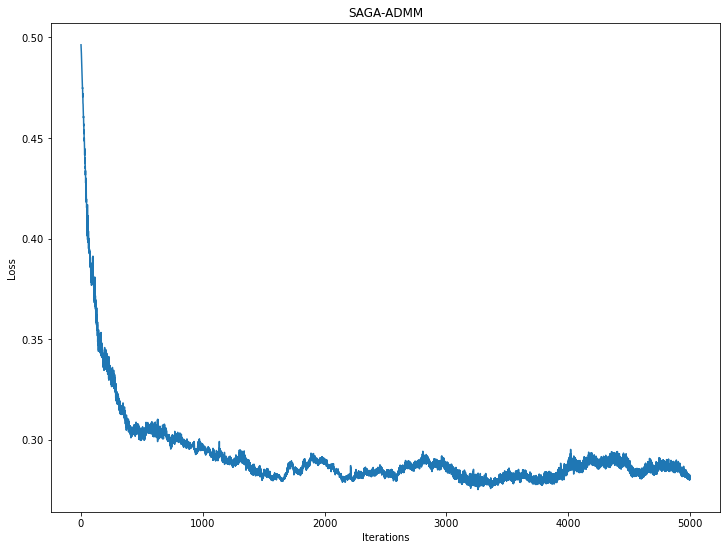

In [66]:
plt.figure(figsize=(12,9))
plt.plot(loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("SAGA-ADMM")